In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
from mppi.Utilities import LatticeUtils as LL
import matplotlib.pyplot as plt
import numpy as np
import os, yaml

# Report of the AGSL5 results

This notebook collects the relevant results achieved for the systems. In this way we aim to plot and analyze the relevant data
without the whole procedure needed to compute them. This procedure is also needed to identify the results the have to be saved 
in order to be able to export and use the (relevant) data only.

## Lattice properties and atomic positions

We extract the atomic positions and lattice properties from the starting input file provided by Vasil

In [3]:
inp = I.PwInput(file='n_5/Input_scf/qe_scf.in')
atoms = inp['atomic_positions']['values'] # provided in angstrom
cell_parameters = inp['cell_parameters']['values'] # provided in angstrom

In [4]:
lattice = np.array(cell_parameters)
positions = LL.build_lattice(lattice,atoms,3,4,1) #3,4

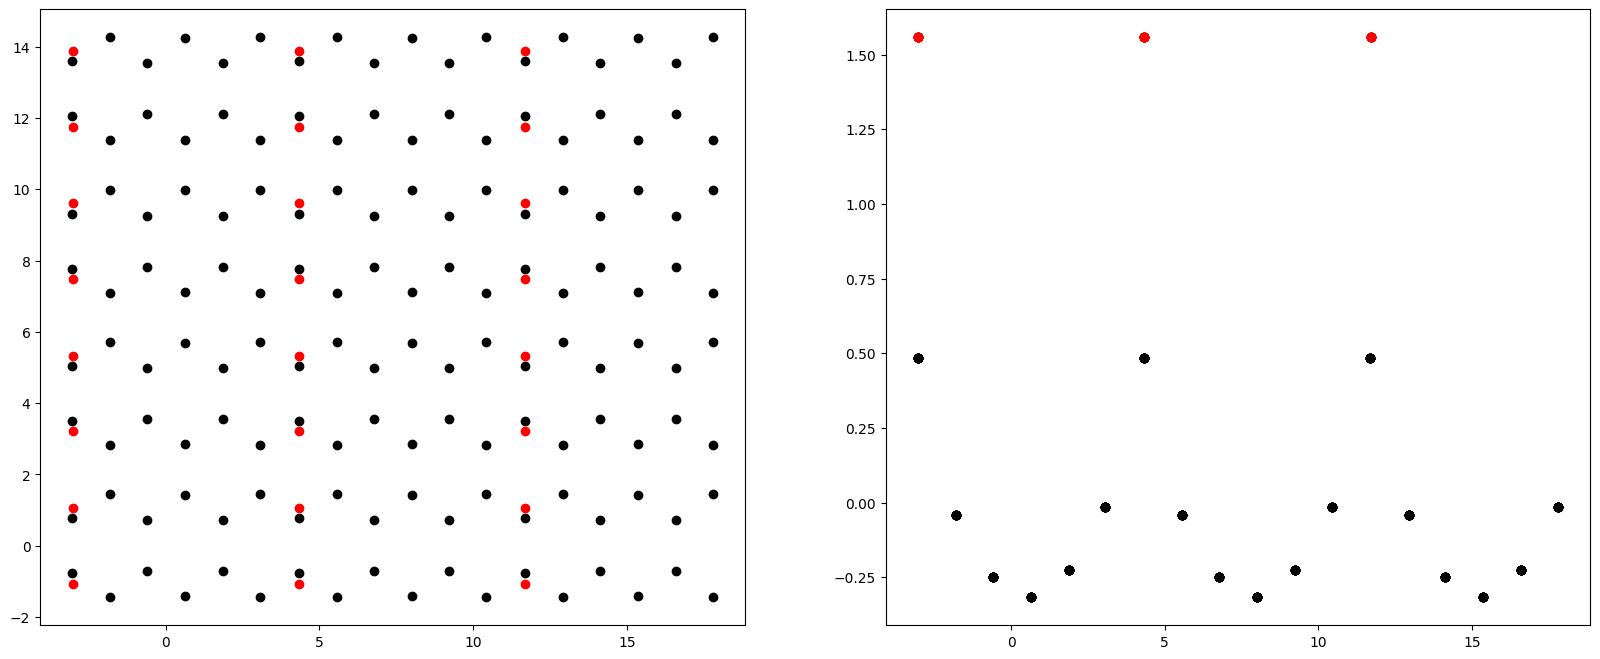

In [5]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
for at in positions:
    if at[0] == 'C': color = 'black'
    if at[0] == 'H': color = 'red'
    ax[0].scatter(at[1],at[2],color=color)
for at in positions:
    if at[0] == 'C': color = 'black'
    if at[0] == 'H': color = 'red'
    ax[1].scatter(at[1],at[3],color=color)


## DFT Analysis

### KS evals and k-point sampling

In [6]:
data = P.PwParser('n_5/DFT_analysis/kpoints_20x40-nbnds_600.xml')
#data.get_gap()

Parse file : n_5/DFT_analysis/kpoints_20x40-nbnds_600.xml


number of kpoints = 231


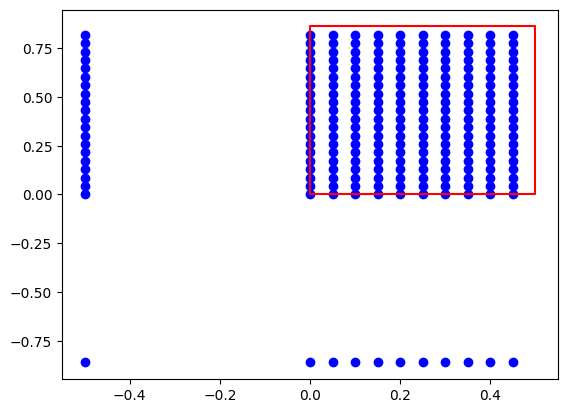

In [7]:
kp = data.kpoints # cartesian coordinates in units of 2\pi/alat

# cartesian  coords
G = np.array([0.0,0.0])
M2 = np.array([0.0,0.8617109])
K = np.array([0.5,0.8617109])
M = np.array([0.5,0.0])

print('number of kpoints = %s'%len(kp))
IBZ = [G,M2,K,M,G]
plt.plot(*np.column_stack(IBZ),color='red')
plt.scatter(kp[:,0],kp[:,1],c='blue')

### Band structure

In [8]:
bands_data = 'n_5/DFT_analysis/bands.save/data-file-schema.xml'

In [9]:
# cartesian  coords
G = [0.0,0.0,0.0]
M2 = [0.0,0.8617109,0.0]
K = [0.5,0.8617109,0.0]
M = [0.5,0.0,0.0]

high_sym = {'G':G,'K':K,'M':M,'M2':M2} # useful to label the high-sym point on the path

bands = U.BandStructure.from_Pw(bands_data,high_sym_points=high_sym)

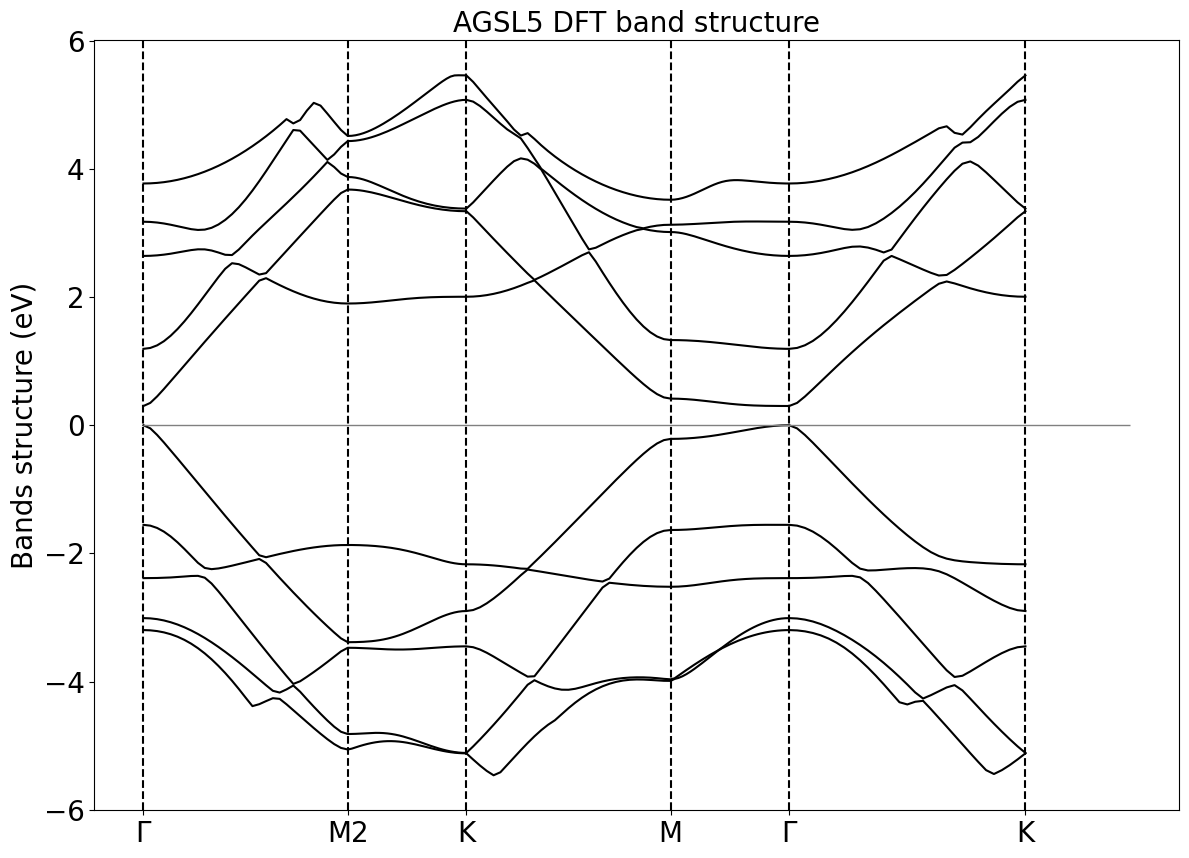

In [10]:
label_size = 20

fig, ax = plt.subplots(figsize=(14, 10))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(20,30)],color='black') #
#bands.plot(plt,selection=[i for i in range(26,30)],color='red')
ax.hlines(0.,0.,4.16,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.set_title('AGSL5 DFT band structure',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

## GW Analysis

### Convergence Analysis

We collect the results of the convergence procedure. In particular we produce the plots the show the dependence
of the gap at Gamma (at pp level).

First we present the results of the convergence in terms of the cutoff on the screening, on the numerb of bands of the screening and
of the number of bands of the G function for a given kpoints sampling.

We start from the energy cutoff of the response function

In [11]:
run_dir = 'n_5/MB_analysis/kpoints_10x20-nbnds_800/'
Gamma_index = 1
start_band,stop_band = 25,26
NGsBlkXp = [4.0,6.0,8.0] # Ha G size of the response function
BndsRnXp  = [1,300] # Bands in the response function
GbndRnge = [1,300] 
verbose = False

gap = []
for ngsblkxp in NGsBlkXp:
    file = os.path.join(run_dir,'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(ngsblkxp,BndsRnXp[1],GbndRnge[1]),
                         'o-pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s.qp'%(ngsblkxp,BndsRnXp[1],GbndRnge[1]))
    data = P.YamboOutputParser.from_file(file,extendOut=True,verbose=verbose)
    gap.append(data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False))
gap

[np.float64(0.9217709999999999),
 np.float64(0.9299519999999999),
 np.float64(0.931984)]

Text(0.5, 0, 'NGsBlkXp (Ha)')

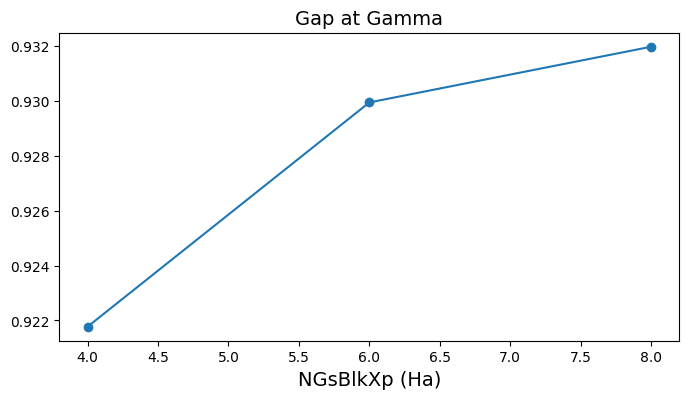

In [12]:
fig, axes = plt.subplots(figsize=(8, 4))
axes.plot(NGsBlkXp,gap)
axes.scatter(NGsBlkXp,gap)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('NGsBlkXp (Ha)',size=14)

We plot the behavior in terms of the number of bands of the response function

In [13]:
run_dir = 'n_5/MB_analysis/kpoints_10x20-nbnds_800/'
Gamma_index = 1
NGsBlkXp = 8.0 # Ha G size of the response function
Bands  = [[1,300],[1,400],[1,500]] # Bands in the response function
GbndRnge = [1,300] 

gap = []
for bands in Bands:
    file = os.path.join(run_dir,'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,bands[1],GbndRnge[1]),
                         'o-pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s.qp'%(NGsBlkXp,bands[1],GbndRnge[1]))
    data = P.YamboOutputParser.from_file(file,extendOut=True,verbose=False)
    gap.append(data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False))
gap

[np.float64(0.931984), np.float64(1.154542), np.float64(1.153888)]

Text(0.5, 0, 'BndsRnXp')

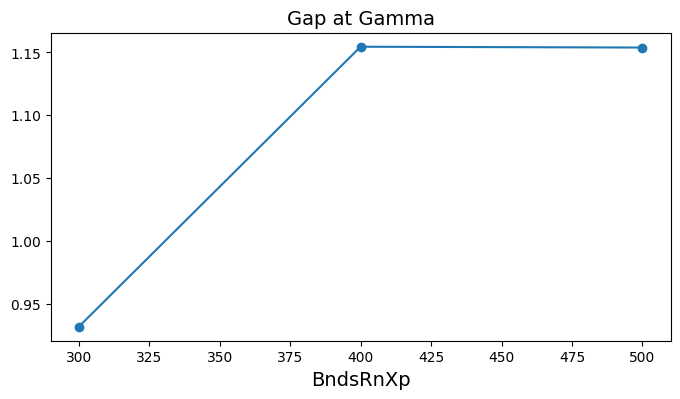

In [14]:
x_vals = [x[1] for x in Bands]

fig, axes = plt.subplots(figsize=(8,4))
axes.plot(x_vals,gap)
axes.scatter(x_vals,gap)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('BndsRnXp',size=14)

We plot the behavior in terms of the number of bands of the response function including both the results with and without the terminator on the bands parameter.

In [15]:
run_dir = 'n_5/MB_analysis/kpoints_10x20-nbnds_800/'
Gamma_index = 1
start_band,stop_band = 25,26
NGsBlkXp = 8.0 # Ha G size of the response function
BndsRnXp = [1,500]
Bands  = [[1,300],[1,400],[1,500],[1,600],[1,700]] # Bands in the G function

gap, gap_Gterm = [],[]
for bands in Bands:
    file = os.path.join(run_dir,'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,BndsRnXp[1],bands[1]),
                         'o-pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s.qp'%(NGsBlkXp,BndsRnXp[1],bands[1]))
    file_Gterm = os.path.join(run_dir,'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s-Gterm'%(NGsBlkXp,BndsRnXp[1],bands[1]),
                         'o-pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s-Gterm.qp'%(NGsBlkXp,BndsRnXp[1],bands[1]))
    data = P.YamboOutputParser.from_file(file,extendOut=True,verbose=False)
    data_Gterm = P.YamboOutputParser.from_file(file_Gterm,extendOut=True,verbose=False)
    gap.append(data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False))
    gap_Gterm.append(data_Gterm.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False))
gap,gap_Gterm

([np.float64(1.153888),
  np.float64(1.1519249999999999),
  np.float64(1.149286),
  np.float64(1.1480569999999999),
  np.float64(1.1468059999999998)],
 [np.float64(1.141799),
  np.float64(1.142014),
  np.float64(1.141872),
  np.float64(1.141928),
  np.float64(1.141921)])

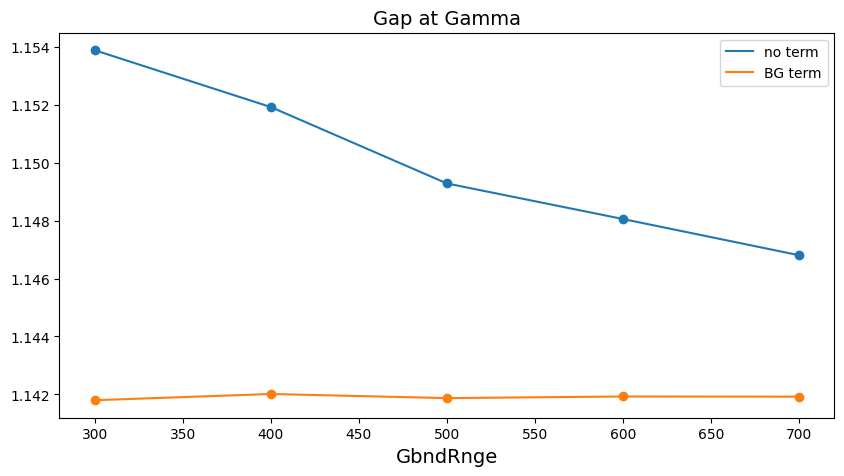

In [16]:
x_vals = [x[1] for x in Bands]

fig, axes = plt.subplots(figsize=(10, 5))
axes.plot(x_vals,gap,label='no term')
axes.scatter(x_vals,gap)
axes.plot(x_vals,gap_Gterm,label='BG term')
axes.scatter(x_vals,gap_Gterm)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('GbndRnge',size=14)
axes.legend()

Finally we plot the behavior of the gaps in function of the number of kpoints 

In [17]:
Gamma_index = 1
start_band,stop_band = 25,26

ksamplings = {'10x20': {'folder':'kpoints_10x20-nbnds_800','npoints':66},
             '15x30': {'folder':'kpoints_15x30-nbnds_600','npoints':128},
             '20x40': {'folder':'kpoints_20x40-nbnds_600','npoints':231},
             '25x50': {'folder':'kpoints_25x50-nbnds_600','npoints':338}
            }

In [18]:
gap = []
for kpoints in ksamplings:
    file = os.path.join('n_5','MB_analysis',ksamplings[kpoints]['folder'],'pp-G-kpoints_%s'%kpoints,'o-pp-G-kpoints_%s.qp'%kpoints)
    data = P.YamboOutputParser.from_file(file,extendOut=True,verbose=False)
    gap.append(data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False))
gap

[np.float64(1.1415469999999999),
 np.float64(1.04211),
 np.float64(0.994708),
 np.float64(0.969077)]

Text(0.5, 0, 'number of kpoints')

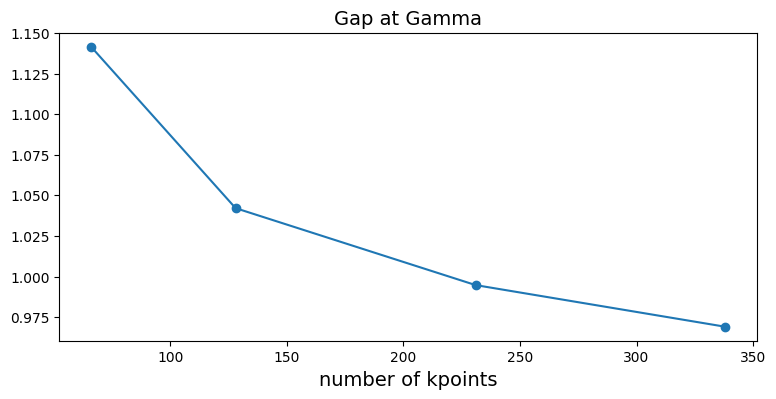

In [19]:
x_vals = [ksamplings[k]['npoints'] for k in ksamplings]

fig, axes = plt.subplots(figsize=(9, 4))
axes.plot(x_vals,gap)
axes.scatter(x_vals,gap)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('number of kpoints',size=14)

### Band Structure

In [20]:
# cryst  coords
G_cryst = [0.0,0.0,0.0]
M2_cryst = [0.0,0.5,0.0]
K_cryst = [0.5,0.5,0.0]
M_cryst = [0.5,0.0,0.0]
high_sym = {'G':G_cryst,'K':K_cryst,'M':M_cryst,'M2':M2_cryst} # useful to label the high-sym point on the path

In [21]:
run_dir = os.path.join('n_5','MB_analysis','kpoints_20x40-nbnds_600')
bands_dft = U.BandStructure.from_Ypp_file(os.path.join(run_dir,'ypp_bands_dft','o-ypp_bands_dft.bands_interpolated'),high_sym_points=high_sym)
bands_gw = U.BandStructure.from_Ypp_file(os.path.join(run_dir,'ypp_bands_gw','o-ypp_bands_gw.bands_interpolated'),high_sym_points=high_sym)

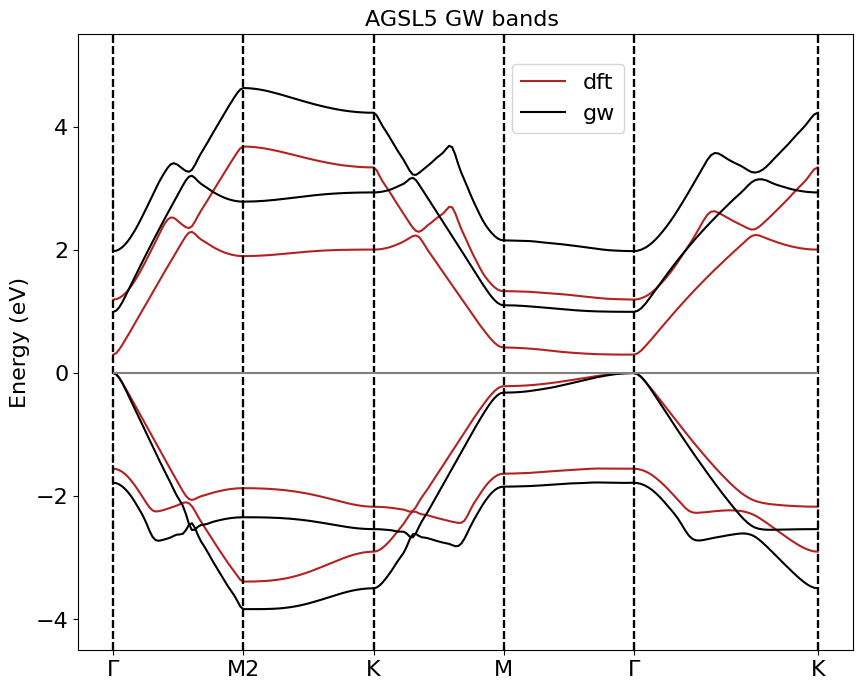

In [22]:
fig, ax1 = plt.subplots(figsize=(10,8))
bands_dft.plot(plt,axes=ax1,selection=[0],linestyle='-',label='dft',c='firebrick')
bands_dft.plot(plt,axes=ax1,selection=[1,2,3],linestyle='-',c='firebrick')
bands_gw.plot(plt,axes=ax1,selection=[0],linestyle='-',label='gw',c='black')
bands_gw.plot(plt,axes=ax1,selection=[1,2,3],linestyle='-',c='black')
ax1.hlines(0.,0.,2.707,linestyles='-',color='gray')
ax1.set_ylim(-4.5,5.5)
ax1.set_ylabel('Energy (eV)',size=16)
ax1.set_title('AGSL5 GW bands ',size=16)
ax1.legend(loc=(0.56,0.84),fontsize=16,frameon=True)
ax1.tick_params(axis='both', which='major', labelsize=16)
plt.savefig(fname='Plot/AGLS5-band-structure.jpg',format='jpeg',bbox_inches = "tight")

## OPTICS

We save the results of the BSE analysis for the various kpoints sampling considered.

For this analysis we use the converged values

BSENGBlk = 3.0 # Ha  
BSEBands = [19,31]

In [41]:
ksamplings = {'10x20': {'folder':'kpoints_10x20-nbnds_800','npoints':66},
             '15x30': {'folder':'kpoints_15x30-nbnds_600','npoints':128},
             '20x40': {'folder':'kpoints_20x40-nbnds_600','npoints':231},
             '25x50': {'folder':'kpoints_25x50-nbnds_600','npoints':338}
            }

start_band,stop_band = 25,26
Gamma_index = 1

for kpoints in ksamplings:
    run_dir=os.path.join('n_5','MB_analysis',ksamplings[kpoints]['folder'])
    file = os.path.join(run_dir,'pp-G-kpoints_%s'%kpoints,'o-pp-G-kpoints_%s.qp'%kpoints)
    data = P.YamboOutputParser.from_file(file)
    ksamplings[kpoints]['gw_gap'] = data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False)
#ksamplings

Parse file n_5\MB_analysis\kpoints_10x20-nbnds_800\pp-G-kpoints_10x20\o-pp-G-kpoints_10x20.qp
Parse file n_5\MB_analysis\kpoints_15x30-nbnds_600\pp-G-kpoints_15x30\o-pp-G-kpoints_15x30.qp
Parse file n_5\MB_analysis\kpoints_20x40-nbnds_600\pp-G-kpoints_20x40\o-pp-G-kpoints_20x40.qp
Parse file n_5\MB_analysis\kpoints_25x50-nbnds_600\pp-G-kpoints_25x50\o-pp-G-kpoints_25x50.qp


In [42]:
alpha_data = []
exc_data = []
for kpoint in ksamplings:
    alpha_file = os.path.join('n_5','MB_analysis',ksamplings[kpoint]['folder'],
                        'bse-bsengblk_3.0-bands_19-31-kpoints_%s'%kpoint,
                        'o-bse-bsengblk_3.0-bands_19-31-kpoints_%s.alpha_q1_slepc_bse'%kpoint)
    exc_file = os.path.join('n_5','MB_analysis',ksamplings[kpoint]['folder'],
                        'bse-bsengblk_3.0-bands_19-31-kpoints_%s'%kpoint,
                        'o-bse-bsengblk_3.0-bands_19-31-kpoints_%s.Esort_q1_slepc_bse'%kpoint)
    alpha_data.append(P.YamboOutputParser.from_file(alpha_file,verbose=False))
    exc_data.append(P.YamboOutputParser.from_file(exc_file,verbose=False))

In [43]:
kpoints = [k for k in ksamplings]
exc_ind = 0 # index of the excitation. 0 = first excitation energy
excitations = []
for ind in range(len(kpoints)):
    excitations.append(exc_data[ind]['Esort_q1_slepc_bse']['energy'][exc_ind])
print(excitations)

[np.float64(0.46048), np.float64(0.501294), np.float64(0.523548), np.float64(0.533724)]


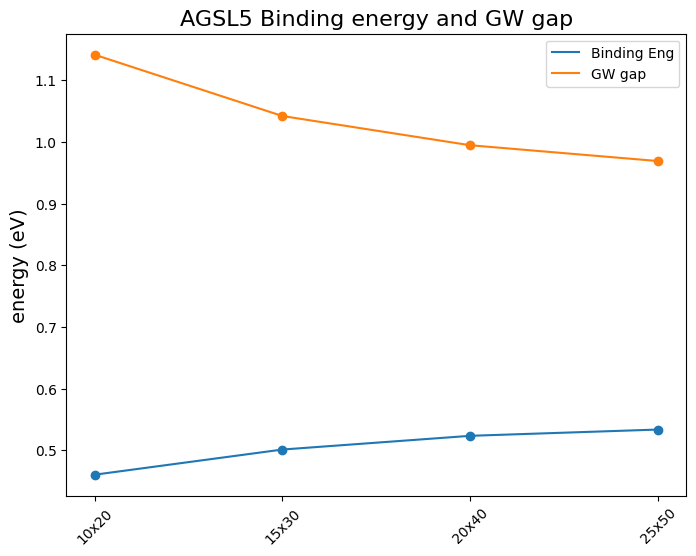

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(kpoints,excitations)
ax.plot(kpoints,excitations,label='Binding Eng')
gw_gaps = [ksamplings[k]['gw_gap'] for k in ksamplings]
ax.scatter(kpoints,gw_gaps)
ax.plot(kpoints,gw_gaps,label='GW gap')
labels = list(ksamplings.keys())
plt.xticks(np.arange(len(kpoints)), kpoints, rotation=45,size=10)
ax.set_title('AGSL5 Binding energy and GW gap',size=16)
ax.set_ylabel('energy (eV)',size=14)
ax.legend()
#ax.set_ylim(0.42,0.55)

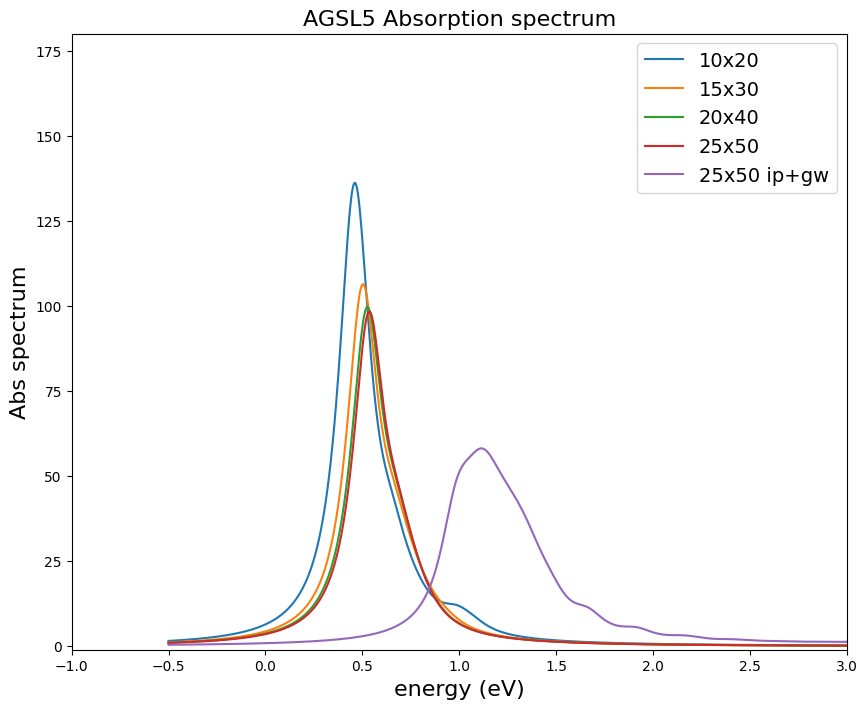

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind in range(len(kpoints)):
    data = alpha_data[ind]['alpha_q1_slepc_bse']
    energy = data['energy']
    alpha_im = data['alpha_imag']
    ax.plot(energy,alpha_im,label=kpoints[ind])
alpha_o_im = alpha_data[-1]['alpha_q1_slepc_bse']['alpha_o_imag']
ax.plot(energy,alpha_o_im,label='25x50 ip+gw') 
ax.set_xlim(-1,3)
ax.set_ylim(-1,180)
ax.set_ylabel('Abs spectrum',size=16)
ax.set_xlabel('energy (eV)',size=16)
ax.set_title('AGSL5 Absorption spectrum',size=16)
ax.legend(fontsize=14)

# Report of the AGSL11 results

## Lattice properties and atomic positions

We extract the atomic positions and lattice properties from the starting input file provided by Vasil

In [28]:
inp = I.PwInput(file='n_6/Input_scf/qe_scf.in')
atoms = inp['atomic_positions']['values'] # provided in angstrom
cell_parameters = inp['cell_parameters']['values'] # provided in angstrom

In [29]:
lattice = np.array(cell_parameters)
positions = LL.build_lattice(lattice,atoms,4,10,1) #3,4

(-10.0, 32.0)

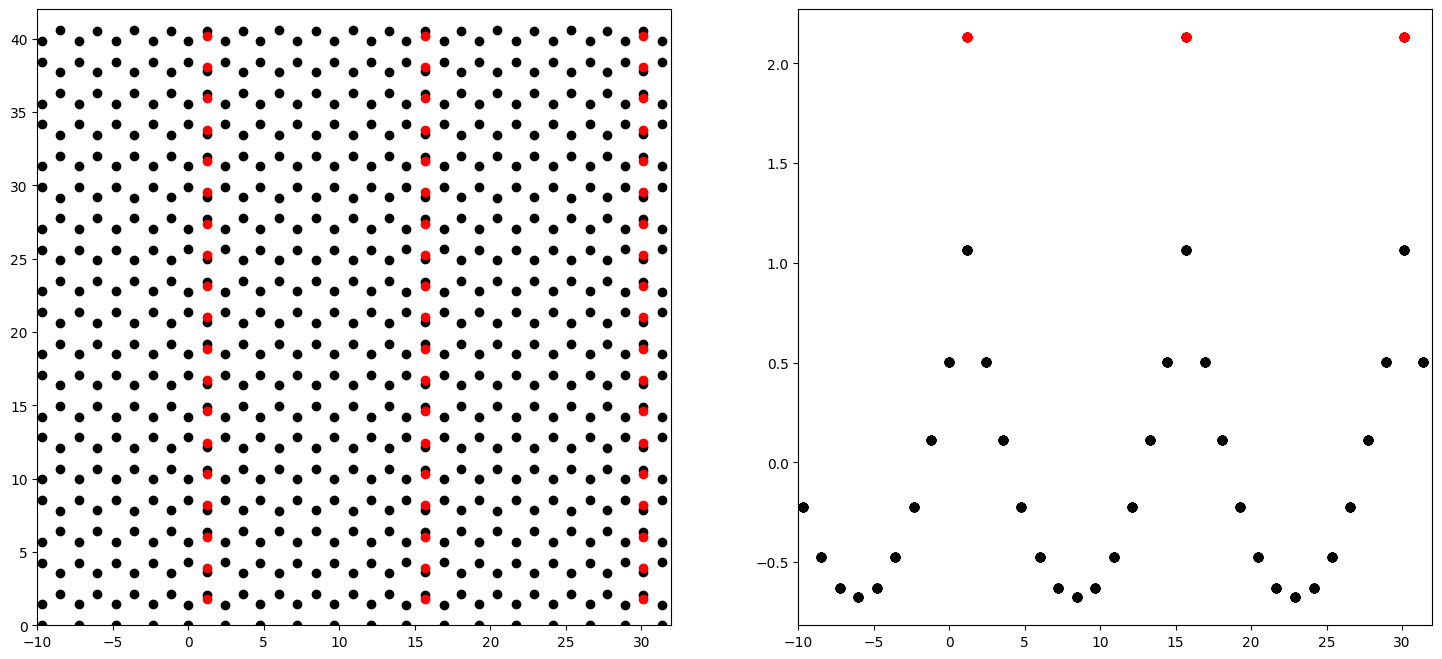

In [30]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,8))
for at in positions:
    if at[0] == 'C': color = 'black'
    if at[0] == 'H': color = 'red'
    ax[0].scatter(at[1],at[2],color=color)
for at in positions:
    if at[0] == 'C': color = 'black'
    if at[0] == 'H': color = 'red'
    ax[1].scatter(at[1],at[3],color=color)
ax[0].set_xlim(-10,32)
ax[0].set_ylim(0,42)
ax[1].set_xlim(-10,32)

## DFT Analysis

### KS evals and k-point sampling

In [31]:
data = P.PwParser('n_6/DFT_analysis/kpoints_12x36-nbnds_600.xml')
#data.get_gap()

Parse file : n_6/DFT_analysis/kpoints_12x36-nbnds_600.xml


number of kpoints = 133


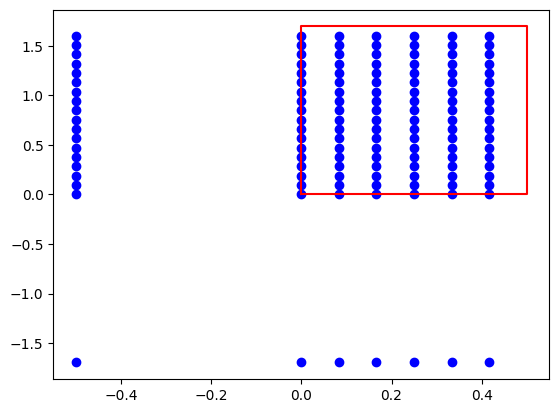

In [32]:
kp = data.kpoints # cartesian coordinates in units of 2\pi/alat

# cartesian  coords
G = [0.0,0.0]
M2 = [0.0,1.694669]
K = [0.5,1.694669]
M = [0.5,0.0]

print('number of kpoints = %s'%len(kp))
IBZ = [G,M2,K,M,G]
plt.plot(*np.column_stack(IBZ),color='red')
plt.scatter(kp[:,0],kp[:,1],c='blue')

### Band structure

In [33]:
bands_data = 'n_6/DFT_analysis/bands.save/data-file-schema.xml'

In [34]:
# cartesian  coords
G = [0.0,0.0,0.0]
M2 = [0.0,1.694669,0.0]
K = [0.5,1.694669,0.0]
M = [0.5,0.0,0.0]

high_sym = {'G':G,'K':K,'M':M,'M2':M2} # useful to label the high-sym point on the path

bands = U.BandStructure.from_Pw(bands_data,high_sym_points=high_sym)

Text(0.5, 1.0, 'AGSL11 DFT band structure')

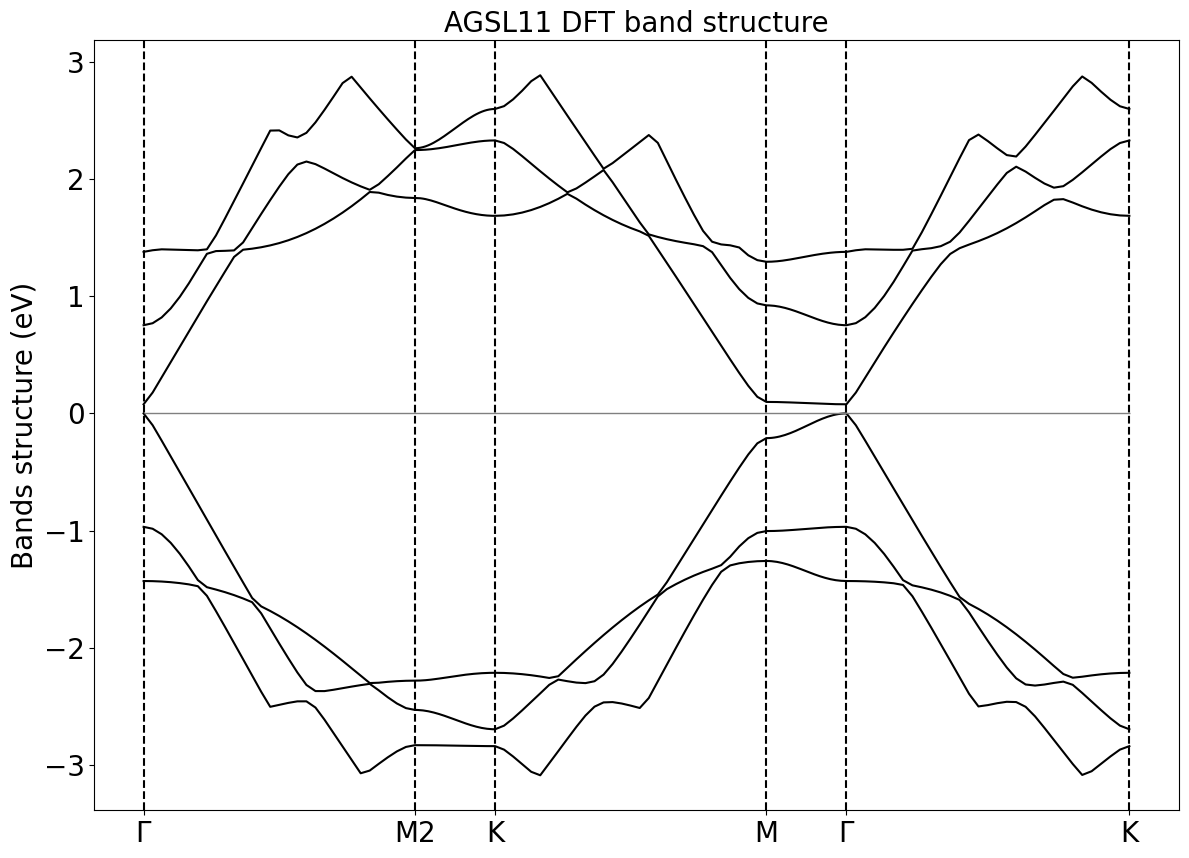

In [35]:
label_size = 20

fig, ax = plt.subplots(figsize=(14, 10))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(46,52)],color='black') #
#bands.plot(plt,selection=[i for i in range(26,30)],color='red')
ax.hlines(0.,0.,6.16,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_title('AGSL11 DFT band structure',size=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

## GW Analysis

### Convergence Analysis

We collect the results of the convergence procedure. In particular we produce the plots the show the dependence
of the gap at Gamma (at pp level).

First we present the results of the convergence in terms of the cutoff on the screening, on the numerb of bands of the screening and
of the number of bands of the G function for a given kpoints sampling.

We start from the energy cutoff of the response function

In [36]:
run_dir = 'n_6/MB_analysis/kpoints_8x24-nbnds_800/'
Gamma_index = 1
start_band,stop_band = 49,50
NGsBlkXp = [4.0,6.0,8.0] # Ha G size of the response function
BndsRnXp  = [1,400] # Bands in the response function
GbndRnge = [1,400] 
verbose = False

gap = []
for ngsblkxp in NGsBlkXp:
    file = os.path.join(run_dir,'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(ngsblkxp,BndsRnXp[1],GbndRnge[1]),
                         'o-pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s.qp'%(ngsblkxp,BndsRnXp[1],GbndRnge[1]))
    data = P.YamboOutputParser.from_file(file,extendOut=True,verbose=verbose)
    gap.append(data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False))
gap

[np.float64(0.28467699999999996),
 np.float64(0.28846499999999997),
 np.float64(0.28894600000000004)]

Text(0.5, 0, 'NGsBlkXp (Ha)')

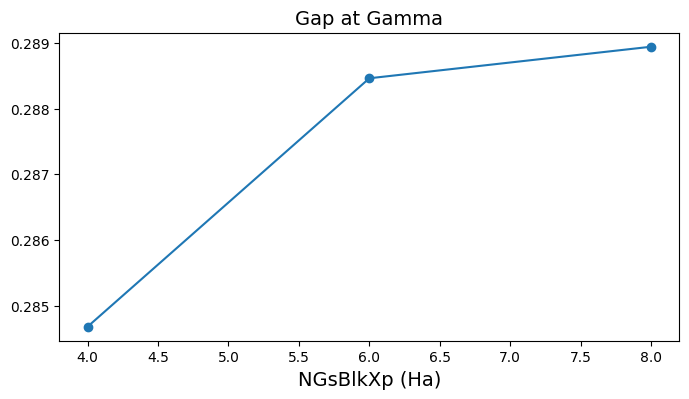

In [37]:
fig, axes = plt.subplots(figsize=(8, 4))
axes.plot(NGsBlkXp,gap)
axes.scatter(NGsBlkXp,gap)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('NGsBlkXp (Ha)',size=14)

We plot the behavior in terms of the number of bands of the response function

In [38]:
run_dir = 'n_6/MB_analysis/kpoints_8x24-nbnds_800/'
Gamma_index = 1
NGsBlkXp = 6.0 # Ha G size of the response function
Bands  = [[1,300],[1,400],[1,500],[1,600]] # Bands in the response function
GbndRnge = [1,400] 

gap = []
for bands in Bands:
    file = os.path.join(run_dir,'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,bands[1],GbndRnge[1]),
                         'o-pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s.qp'%(NGsBlkXp,bands[1],GbndRnge[1]))
    data = P.YamboOutputParser.from_file(file,extendOut=True,verbose=False)
    gap.append(data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False))
gap

[np.float64(0.288879),
 np.float64(0.28846499999999997),
 np.float64(0.288676),
 np.float64(0.289187)]

Text(0.5, 0, 'BndsRnXp')

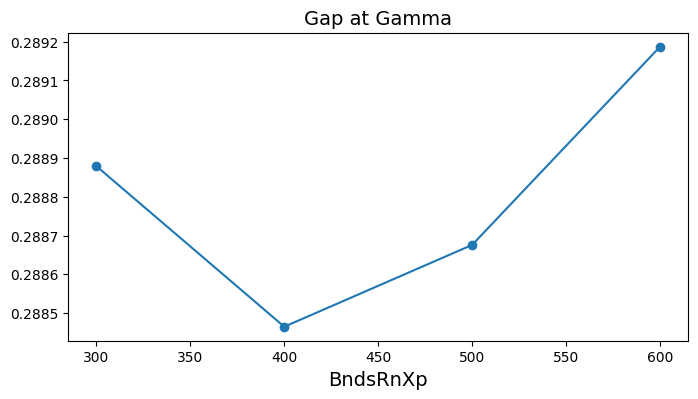

In [39]:
x_vals = [x[1] for x in Bands]

fig, axes = plt.subplots(figsize=(8,4))
axes.plot(x_vals,gap)
axes.scatter(x_vals,gap)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('BndsRnXp',size=14)

We plot the behavior in terms of the number of bands of the response function including both the results with and without the terminator on the bands parameter.

In [40]:
run_dir = 'n_6/MB_analysis/kpoints_8x24-nbnds_800/'
Gamma_index = 1
start_band,stop_band = 49,50
NGsBlkXp = 6.0 # Ha G size of the response function
BndsRnXp = [1,500]
Bands  = [[1,300],[1,400],[1,500],[1,700],[1,800]] # Bands in the G function

gap, gap_Gterm = [],[]
for bands in Bands:
    file = os.path.join(run_dir,'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,BndsRnXp[1],bands[1]),
                         'o-pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s.qp'%(NGsBlkXp,BndsRnXp[1],bands[1]))
    file_Gterm = os.path.join(run_dir,'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s-Gterm'%(NGsBlkXp,BndsRnXp[1],bands[1]),
                         'o-pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s-Gterm.qp'%(NGsBlkXp,BndsRnXp[1],bands[1]))
    data = P.YamboOutputParser.from_file(file,extendOut=True,verbose=False)
    data_Gterm = P.YamboOutputParser.from_file(file_Gterm,extendOut=True,verbose=False)
    gap.append(data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False))
    gap_Gterm.append(data_Gterm.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False))
gap,gap_Gterm

([np.float64(0.283517),
  np.float64(0.288676),
  np.float64(0.29207500000000003),
  np.float64(0.295159),
  np.float64(0.296865)],
 [np.float64(0.30132000000000003),
  np.float64(0.302191),
  np.float64(0.302679),
  np.float64(0.30286900000000005),
  np.float64(0.303087)])

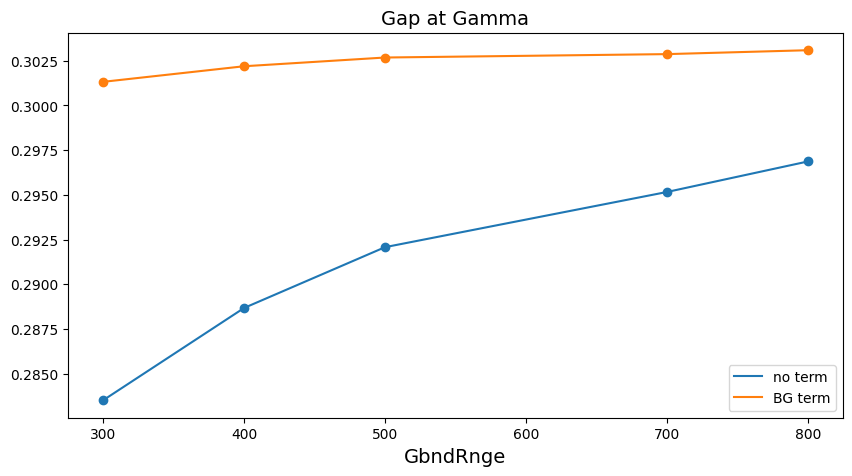

In [41]:
x_vals = [x[1] for x in Bands]

fig, axes = plt.subplots(figsize=(10, 5))
axes.plot(x_vals,gap,label='no term')
axes.scatter(x_vals,gap)
axes.plot(x_vals,gap_Gterm,label='BG term')
axes.scatter(x_vals,gap_Gterm)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('GbndRnge',size=14)
axes.legend()

Finally we plot the behavior of the gaps in function of the number of kpoints 

In [46]:
Gamma_index = 1
start_band,stop_band = 49,50

ksamplings = {'5x15': {'folder':'kpoints_5x15-nbnds_600','npoints':24},
             '8x24': {'folder':'kpoints_8x24-nbnds_800','npoints':65},
             '12x36': {'folder':'kpoints_12x36-nbnds_600','npoints':133},
            }

In [47]:
gap = []
for kpoints in ksamplings:
    file = os.path.join('n_6','MB_analysis',ksamplings[kpoints]['folder'],'pp-G-kpoints_%s'%kpoints,'o-pp-G-kpoints_%s.qp'%kpoints)
    data = P.YamboOutputParser.from_file(file,extendOut=True,verbose=False)
    gap.append(data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False))
gap

[np.float64(0.253946), np.float64(0.302679), np.float64(0.321425)]

Text(0.5, 0, 'number of kpoints')

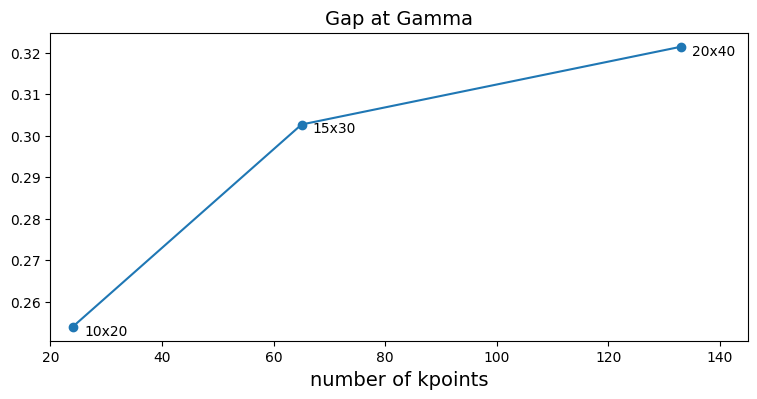

In [48]:
x_vals = [ksamplings[k]['npoints'] for k in ksamplings]

fig, axes = plt.subplots(figsize=(9, 4))
axes.plot(x_vals,gap)
axes.scatter(x_vals,gap)
for ind in range(len(ksamplings)):
    axes.text(x_vals[ind]+2,gap[ind]-0.002,labels[ind])
axes.set_xlim(20,145)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('number of kpoints',size=14)

### Band Structure

In [49]:
# cryst  coords
G_cryst = [0.0,0.0,0.0]
M2_cryst = [0.0,0.5,0.0]
K_cryst = [0.5,0.5,0.0]
M_cryst = [0.5,0.0,0.0]
high_sym = {'G':G_cryst,'K':K_cryst,'M':M_cryst,'M2':M2_cryst} # useful to label the high-sym point on the path

In [50]:
run_dir = os.path.join('n_6','MB_analysis','kpoints_12x36-nbnds_600')
bands_dft = U.BandStructure.from_Ypp_file(os.path.join(run_dir,'ypp_bands_dft','o-ypp_bands_dft.bands_interpolated'),high_sym_points=high_sym)
bands_gw = U.BandStructure.from_Ypp_file(os.path.join(run_dir,'ypp_bands_gw','o-ypp_bands_gw.bands_interpolated'),high_sym_points=high_sym)

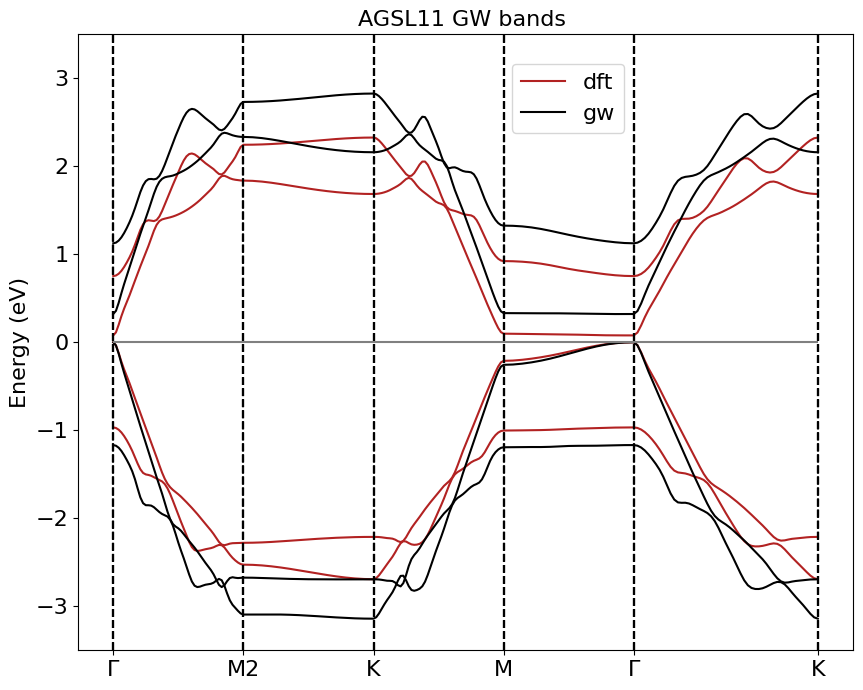

In [51]:
fig, ax1 = plt.subplots(figsize=(10,8))
bands_dft.plot(plt,axes=ax1,selection=[0],linestyle='-',label='dft',c='firebrick')
bands_dft.plot(plt,axes=ax1,selection=[1,2,3],linestyle='-',c='firebrick')
bands_gw.plot(plt,axes=ax1,selection=[0],linestyle='-',label='gw',c='black')
bands_gw.plot(plt,axes=ax1,selection=[1,2,3],linestyle='-',c='black')
ax1.hlines(0.,0.,2.707,linestyles='-',color='gray')
ax1.set_ylim(-3.5,3.5)
ax1.set_ylabel('Energy (eV)',size=16)
ax1.set_title('AGSL11 GW bands ',size=16)
ax1.legend(loc=(0.56,0.84),fontsize=16,frameon=True)
ax1.tick_params(axis='both', which='major', labelsize=16)

## OPTICS

We save the results of the BSE analysis for the various kpoints sampling considered.

For this analysis we use the converged values

BSENGBlk = 3.0 # Ha  
BSEBands = [46,53]

In [8]:
ksamplings = {'5x15': {'folder':'kpoints_5x15-nbnds_600','npoints':24},
             '8x24': {'folder':'kpoints_8x24-nbnds_800','npoints':65},
             '12x36': {'folder':'kpoints_12x36-nbnds_600','npoints':133},
            }

start_band,stop_band = 49,50
Gamma_index = 1

for kpoints in ksamplings:
    run_dir=os.path.join('n_6','MB_analysis',ksamplings[kpoints]['folder'])
    file = os.path.join(run_dir,'pp-G-kpoints_%s'%kpoints,'o-pp-G-kpoints_%s.qp'%kpoints)
    data = P.YamboOutputParser.from_file(file)
    ksamplings[kpoints]['gw_gap'] = data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False)
#ksamplings

Parse file n_6\MB_analysis\kpoints_5x15-nbnds_600\pp-G-kpoints_5x15\o-pp-G-kpoints_5x15.qp
Parse file n_6\MB_analysis\kpoints_8x24-nbnds_800\pp-G-kpoints_8x24\o-pp-G-kpoints_8x24.qp
Parse file n_6\MB_analysis\kpoints_12x36-nbnds_600\pp-G-kpoints_12x36\o-pp-G-kpoints_12x36.qp


In [9]:
alpha_data = []
exc_data = []
for kpoint in ksamplings:
    alpha_file = os.path.join('n_6','MB_analysis',ksamplings[kpoint]['folder'],
                        'bse-bsengblk_3.0-bands_46-53-kpoints_%s'%kpoint,
                        'o-bse-bsengblk_3.0-bands_46-53-kpoints_%s.alpha_q1_slepc_bse'%kpoint)
    exc_file = os.path.join('n_6','MB_analysis',ksamplings[kpoint]['folder'],
                        'bse-bsengblk_3.0-bands_46-53-kpoints_%s'%kpoint,
                        'o-bse-bsengblk_3.0-bands_46-53-kpoints_%s.Esort_q1_slepc_bse'%kpoint)
    alpha_data.append(P.YamboOutputParser.from_file(alpha_file,verbose=False))
    exc_data.append(P.YamboOutputParser.from_file(exc_file,verbose=False))

In [10]:
kpoints = [k for k in ksamplings]
exc_ind = 0 # index of the excitation. 0 = first excitation energy
excitations = []
for ind in range(len(kpoints)):
    excitations.append(exc_data[ind]['Esort_q1_slepc_bse']['energy'][exc_ind])
print(excitations)

[np.float64(0.086916), np.float64(0.120547), np.float64(0.142797)]


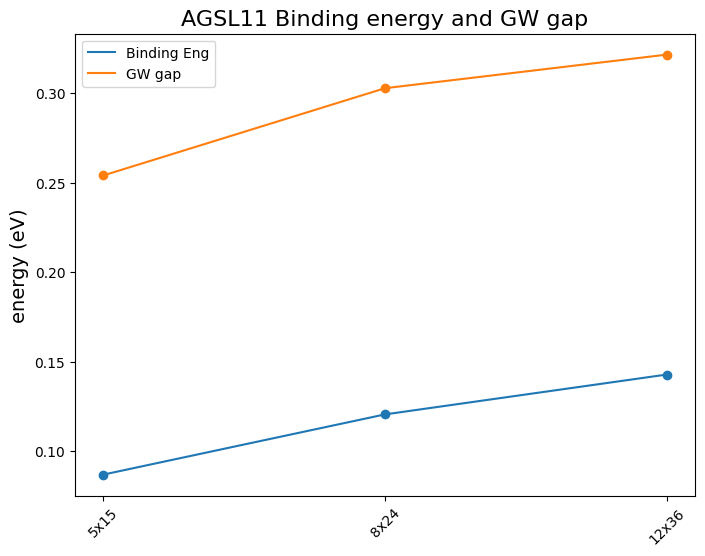

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(kpoints,excitations)
ax.plot(kpoints,excitations,label='Binding Eng')
gw_gaps = [ksamplings[k]['gw_gap'] for k in ksamplings]
ax.scatter(kpoints,gw_gaps)
ax.plot(kpoints,gw_gaps,label='GW gap')
labels = list(ksamplings.keys())
plt.xticks(np.arange(len(kpoints)), kpoints, rotation=45,size=10)
ax.set_title('AGSL11 Binding energy and GW gap',size=16)
ax.set_ylabel('energy (eV)',size=14)
ax.legend()
#ax.set_ylim(0.42,0.55)

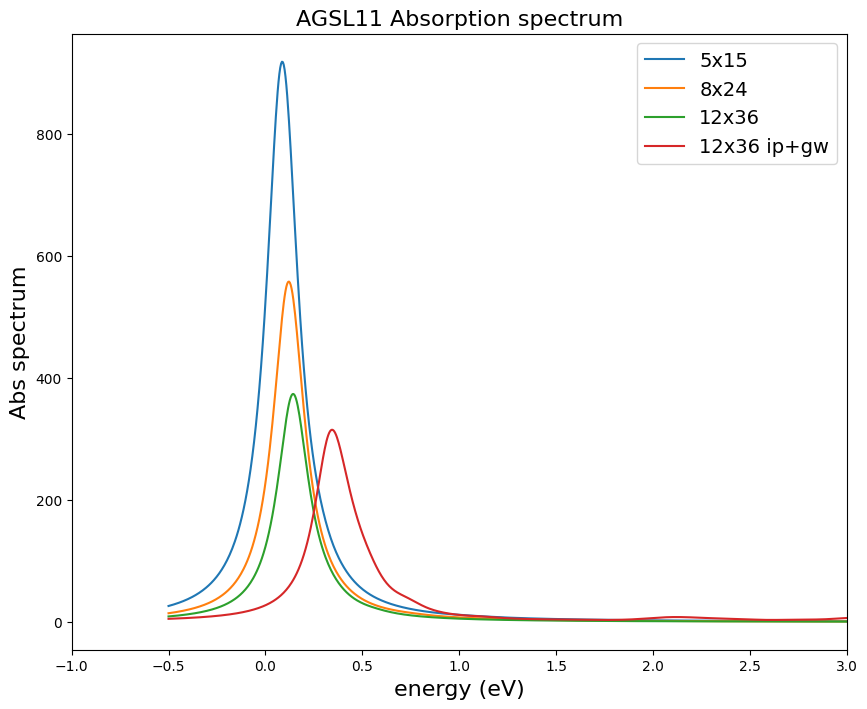

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind in range(len(kpoints)):
    data = alpha_data[ind]['alpha_q1_slepc_bse']
    energy = data['energy']
    alpha_im = data['alpha_imag']
    ax.plot(energy,alpha_im,label=kpoints[ind])
alpha_o_im = alpha_data[-1]['alpha_q1_slepc_bse']['alpha_o_imag']
ax.plot(energy,alpha_o_im,label='12x36 ip+gw') 
ax.set_xlim(-1,3)
#ax.set_ylim(-1,800)
ax.set_ylabel('Abs spectrum',size=16)
ax.set_xlabel('energy (eV)',size=16)
ax.set_title('AGSL11 Absorption spectrum',size=16)
ax.legend(fontsize=14)

# Report of the DFT results for graphene with rectangular lattice vectors

We show the band structure for graphene described within the rectangular lattice. In this description the smallest cell contains
4 C atoms, however we adopt a supercell with 12 C atoms so to match the one used for the corresponding system with the H stripes.

In [14]:
inp = I.PwInput(file='graphene_rect/DFT_analysis/gs_converged_from_AGSL5.in')
atoms = inp['atomic_positions']['values'] # provided in angstrom
cell_parameters = inp['cell_parameters']['values'] # provided in angstrom

In [15]:
lattice = np.array(cell_parameters)
positions = LL.build_lattice(lattice,atoms,1,1,1)

(-4.0, 8.0)

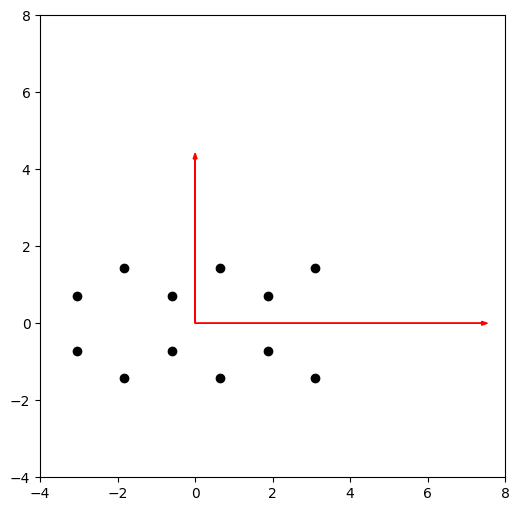

In [16]:
fig, ax = plt.subplots(figsize=(6,6))
for at in positions:
    ax.scatter(at[1],at[2],color='black')
ax.arrow(0,0,lattice[0][0],lattice[0][1],head_width=0.1,color='red')
ax.arrow(0,0,lattice[1][0],lattice[1][1],head_width=0.1,color='red')
ax.set_xlim(-4,8)
ax.set_ylim(-4,8)

### Band structure

In [17]:
bands_data = 'graphene_rect/DFT_analysis/bands.save/data-file-schema.xml'

In [18]:
# cartesian  coords
G = [0.0,0.0,0.0]
M2 = [0.0,0.8617109,0.0]
K = [0.5,0.8617109,0.0]
M = [0.5,0.0,0.0]

high_sym = {'G':G,'K':K,'M':M,'M2':M2} # useful to label the high-sym point on the path

bands = U.BandStructure.from_Pw(bands_data,high_sym_points=high_sym)

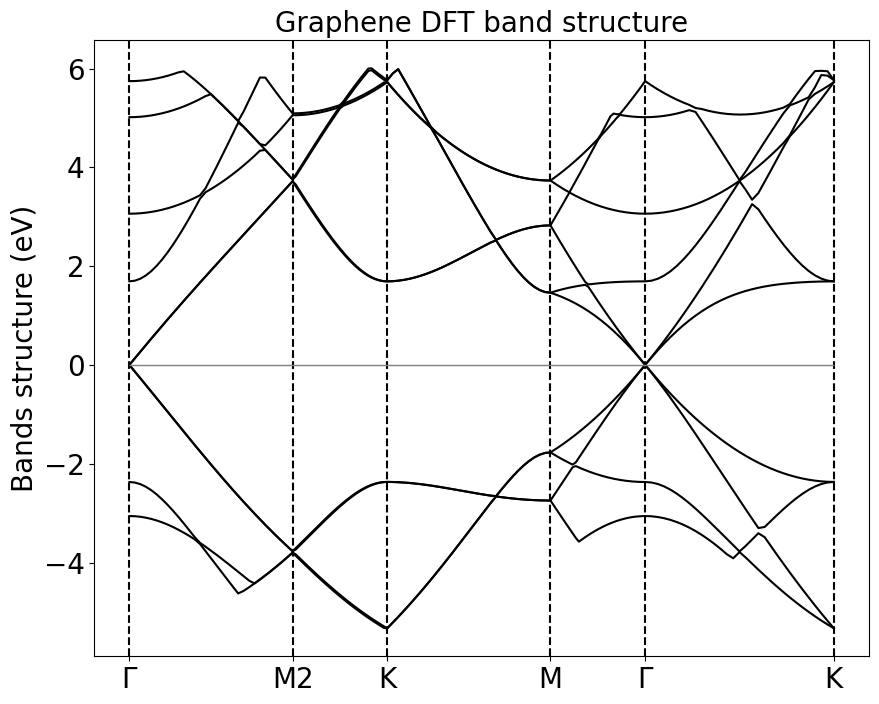

In [19]:
label_size = 20

fig, ax = plt.subplots(figsize=(10, 8))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(20,30)],color='black') #
#bands.plot(plt,selection=[i for i in range(26,30)],color='red')
ax.hlines(0.,0.,3.72,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.set_title('Graphene DFT band structure',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

We plot the path in the k space

In [21]:
data = P.PwParser('graphene_rect/DFT_analysis/bands.save/data-file-schema.xml')

Parse file : graphene_rect/DFT_analysis/bands.save/data-file-schema.xml


In [22]:
data.lattice

array([[1.39710227e+01, 1.89067099e-06, 0.00000000e+00],
       [3.40150702e-09, 8.06716121e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.71943752e+01]])

In [23]:
data.alat

13.97102272655

In [29]:
rec_lat = data.get_reciprocal_lattice(rescale=True)
rec_lat[0]

array([ 1.00000000e+00, -4.21648575e-10,  0.00000000e+00])

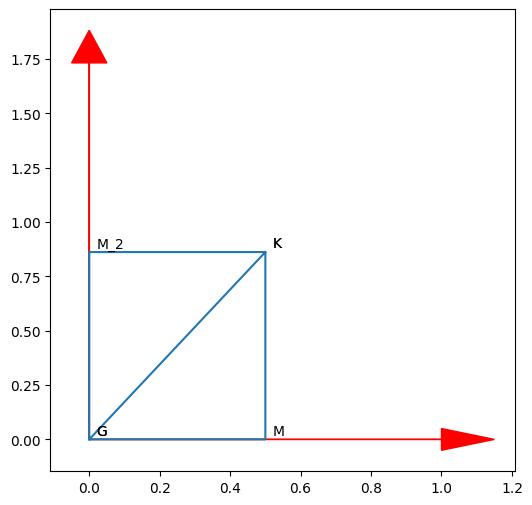

In [40]:
G = [0.0,0.0]
M2 = [0.0,0.8617109]
K = [0.5,0.8617109]
M = [0.5,0.0]

path = [G,M2,K,M,G,K]
path_lbl = ['G','M_2','K','M','G','K']
x,y = [p[0] for p in path],[p[1] for p in path]


fig, ax = plt.subplots(figsize=(6,6))
plt.plot(x,y)
ax.arrow(0,0,rec_lat[0][0],rec_lat[0][1],head_width=0.1,color='red')
ax.arrow(0,0,rec_lat[1][0],rec_lat[1][1],head_width=0.1,color='red')
for ind in range(len(path)):
    plt.text(path[ind][0]+0.02,path[ind][1]+0.02,path_lbl[ind])
#ax.set_xlim(-4,8)
#ax.set_ylim(-4,8)